In [1]:
import qutip
from qutip import *
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
from sklearn.preprocessing import normalize
from scipy import linalg
from scipy.linalg import expm, sinm, cosm

D:\anacondafinal\lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
# Pauli Matrices
sigmaZ = sp.csc_matrix([[1, 0], [0, -1]])
sigmaX = sp.csc_matrix([[0, 1], [1, 0]])
sigmaY = sp.csc_matrix([[0, -1j], [1j, 0]])
sigmaI = sp.csc_matrix([[1, 0], [0, 1]])
sigmaH = sp.csc_matrix([[1, 1], [1, -1]])

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
I = np.array([[1, 0], [0, 1]])

H = np.array([[1, 1], [1, -1]])

In [3]:
params = {
'N' : 1,
'tau_list':[1, 0.5, 0.1, 0.05],
'tau': 0.1,
'n': 2,
'alpha': 1,
'T': 10,
'opH': [X, Y], # Need to change this specific to Model
'pulses': [I, Z] # Need to change this specific to Model
}

def normalizeWF(psi,**kwargs):
    shape, dtype = psi.shape, psi.dtype
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF

def sparseMatrices(a, **kwargs):
    return sp.csc_matrix(a)
      
def tensorOperators(matrix2D, **kwargs):
    return reduce(sp.kron, (sp.eye(2**kwargs['a']), matrix2D , sp.eye(2**kwargs['b'])))

def initialVals(params, **kwargs):
    n = params['n']
    N = params['N']
    alpha = params['alpha']
    op = params['opH']
    pulses = params['pulses']
    r = list(np.random.randint(low = 1,high=30,size=N))
    R = [np.power(1/x, alpha) for x in r]
    # r = np.random.random_sample(size = 2**N)
    psi0 = np.random.randn(2**N)
    psi_nm = normalizeWF(psi0)
    return n, N, r, op, pulses, psi_nm, R, alpha
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)

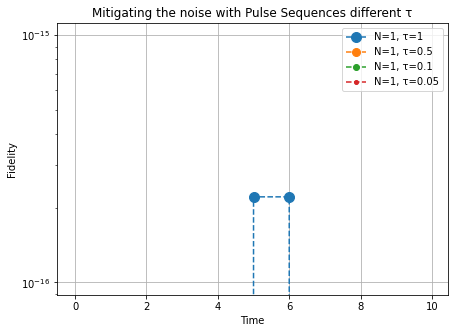

C:\Users\barbi\AppData\Local\Temp\ipykernel_9324\2129624388.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


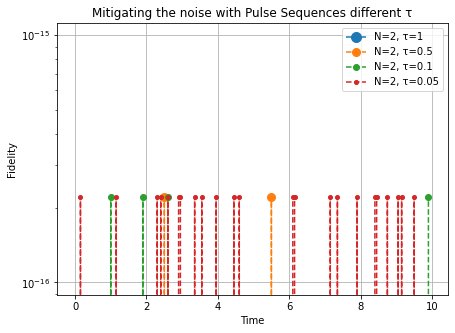

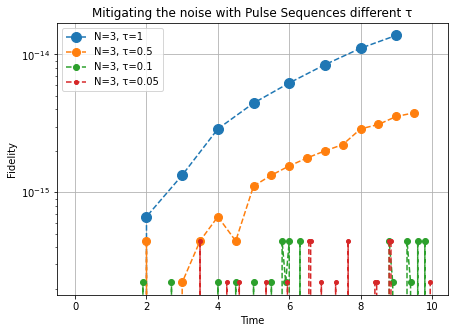

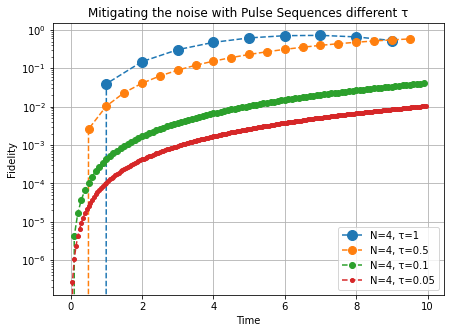

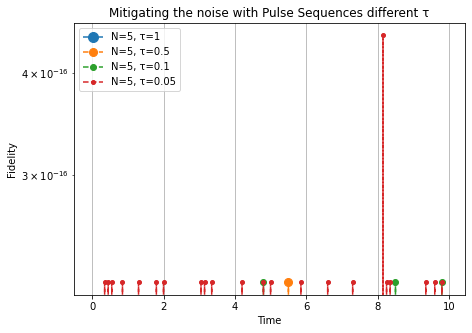

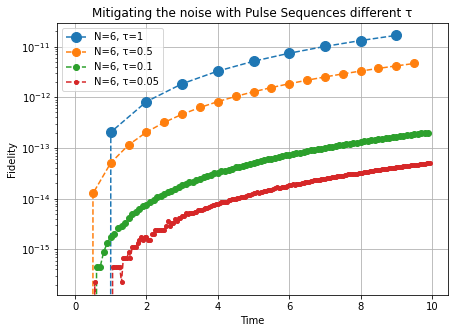

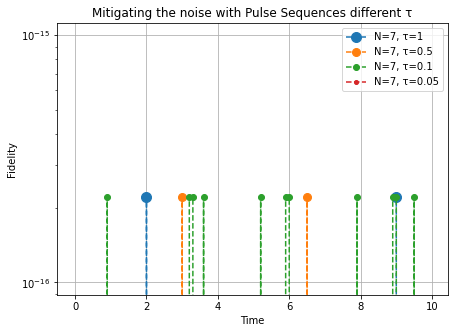

In [44]:
def TogglingFrameH(params, **kwargs):
    N, TFH = params['N'], []
    Hk, matrx = np.zeros((2**N,2**N)), np.zeros((2, 2))
    pulses, opH = params['pulses'], params['opH']
    for p in pulses:
        for op in opH:
            for i in range(N):
                matrx = sparseMatrices(p@op@(np.linalg.inv(p)))
                Hk += R[i]*tensorOperators(matrx, a = i, b = N-1-i)
        TFH.append(Hk)
        Hk, matrx = np.zeros((2**N,2**N)), np.zeros((2, 2))
    return TFH

TFH = TogglingFrameH(params)
# print(TFH)

def TimeEvolOpForTFH(params, **kwargs):
    TFH, unitary_timeOp, expTFH, tau, n = kwargs['TFH'], [], np.eye(2**params['N']), params['tau'], params['n']
    for i, hk in enumerate(TFH):
        expTFH = expm(-1j*tau*hk/n) @ expTFH
    t_list = np.arange(0, params['T'], tau)
    unitary_timeOp = [np.linalg.matrix_power(expTFH, i) for i, t in enumerate(t_list)]
    return unitary_timeOp, t_list
unitary_timeOp, t_list = TimeEvolOpForTFH(params, TFH = TogglingFrameH(params))

for i in range(1, 8, 1):
    params['N'] = i
    params['n'] = 4
    params['pulses'] = [I, Z, X, Y]
    params['opH'] = [Y, X, Z]
    params['alpha'] = 6
    n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)

    mss=10

    # print(params['tau_list'])

    plt.figure(figsize=[7,5])
    for tau in params['tau_list']:
        params['tau'] = tau
        F = []
        uOp, t = TimeEvolOpForTFH(params, TFH = TogglingFrameH(params))   
        psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
        F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
    #     print(F)
        plt.plot(t, F, "--o", label = f"N={params['N']}, τ={tau}", ms=mss)
        mss -=2
        plt.yscale("log")
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Fidelity")
        plt.title("Mitigating the noise with Pulse Sequences different τ")
        plt.grid('on')
    plt.show()

In [13]:
def H_noise(params, **kwargs):
    N = params['N']
    op = params['opH']
    Hnoise = np.zeros((2**N, 2**N))
    for i in range(N):
        Hnoise += tensorOperators(sparseMatrices(op[0]), a = i, b = N-1-i)
    return Hnoise
# print(H_noise(params))    

def utimeOpH(params, **kwargs):
    H = kwargs['H']
    t_list = np.arange(0,1, params['tau'])
    unitary_timeOp = [expm(-1j*t*H) for t in t_list]
    return unitary_timeOp, t_list

def TogglingFrameH(params, **kwargs):
    N, TFH = params['N'], []
    Hk, matrx = np.zeros((2**N,2**N)), np.zeros((2, 2))
    pulses, opH = params['pulses'], params['opH']
    for p in pulses:
        for op in opH:
            for i in range(N):
                matrx = sparseMatrices(p@op@(np.linalg.inv(p)))
                Hk += R[i]*tensorOperators(matrx, a = i, b = N-1-i)
        TFH.append(Hk)
        Hk, matrx = np.zeros((2**N,2**N)), np.zeros((2, 2))
    return TFH
# TFH = TogglingFrameH(params)
# print(TFH)

def avgHFromTogglingFrameH(params, **kwargs):
    n = params['n']
    N = params['N']
    avgH = np.zeros((2**N, 2**N))
    TFH  = kwargs['TFH']
    avgH = sum(TFH)/len(TFH)
    return avgH
# print(avgHFromTogglingFrameH(params))

def TimeEvolOpForTFH(params, **kwargs):
    TFH, unitary_timeOp, expTFH, tau, n, T = kwargs['TFH'], [], np.eye(2**params['N']), params['tau'], params['n'], params['T']
    for i, hk in enumerate(TFH):
        expTFH = expm(-1j*tau*hk/n) @ expTFH
    t_list = np.arange(0, 10, tau)
    unitary_timeOp = [np.linalg.matrix_power(expTFH, i) for i, t in enumerate(t_list)]
    return unitary_timeOp, t_list
unitary_timeOp, t_list = TimeEvolOpForTFH(params, TFH = TogglingFrameH(params))
    
def F_tvals(params, **kwargs):
    H, Utop_present = kwargs['H'], kwargs['Utop_present']
    H_present = kwargs['H_present']
    F_t, Ft2, T_list, UToP = [], [], [], []
    for i in params['tau_list']:
        params['tau'] = i
        if H_present == 'True':
            unitary_timeOp, t_list = utimeOpH(params, H = H)
        elif Utop_present == 'True':
            unitary_timeOp, t_list = TFHutimeOp(params, H = H)
        UToP.append(unitary_timeOp)
        T_list.append(t_list)
        psi_t = [normalizeWF(np.matmul(unitary_timeOp[i],psi_nm)) for i in range(len(unitary_timeOp))]
        F_t.append([np.power(np.vdot(psi_nm, pt), 2) for pt in psi_t])
#         Ft2 = [1-f for i in range(len(F_t)) for f in F_t[i]]
#         t_list = [(i**2)*j**2 for j in t_list]
#         plt.figure(figsize=[7,5])
#         plt.plot( t_list, Ft2, label = f"N={params['N']}, τ={params['tau']}")
#         plt.xlabel("$\mathregular{(τT)^2}$")
#         plt.ylabel("$\mathregular{(1 - F)}$")
#         plt.grid('on')
#         plt.legend()
        Ft2 = []
    plt.show()
    return unitary_timeOp, psi_t, F_t, Ft2, T_list, UToP

def plottingFidelityVsTaus(params, **kwargs):
    Utop_present = kwargs['Utop_present']
    H_present = kwargs['H_present']
    unitary_timeOp, psi_t, F_t, Ft2, T_list, UToP = F_tvals(params, H = H, H_present = H_present, Utop_present = Utop_present)
    plt.figure(figsize=[7,5])
    plt.xlabel("Time")
    plt.ylabel("Fidelity")
    plt.title("Mitigating the noise with Pulse Sequences different τ")
    plt.grid('on')
    for i in range(len(F_t)):
        plt.plot( T_list[i], F_t[i], label = f"N={params['N']}, τ={params['tau_list'][i]}")
        plt.legend()
    plt.show()
    pass

params['opH'] = [X, Y, Z]
params['pulses'] = [I, X, Y, Z]
params['n'] = 4
# H = avgHFromTogglingFrameH(params, TFH = TogglingFrameH(params))
# plottingFidelityVsTaus(params, H = H, H_present = 'True', Utop_present = 'False')
# print(utimeOp(params, H = H, H_present = 'True', Utop_present = 'False'))
# print(H)

# H = utopFromTFH(params, TFH = TogglingFrameH(params))
# plottingFidelityVsTaus(params, H = H, H_present = 'False', Utop_present = 'True')
# print(TFHutimeOp(params, H = H, H_present = 'True', Utop_present = 'False'))
# print(H)

In [36]:
params['N'] = 5
params['opH'] = [X]
params['pulses'] = [I, Z]
params['n'] = 2
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)
def TogglingFrame_Ising(params, **kwargs):
    N = params['N']
    TFH = []
    pulses = params['pulses']
    for p in pulses:
        Hk, matrx1, matrx2 = np.zeros((2**N, 2**N), dtype=complex), np.zeros((2, 2)), np.zeros((2, 2)) 
        for op in params['opH']:
            for i in range(N-1):
                matrx1 = sparseMatrices(op)
                matrx2 = sparseMatrices(op)
                if N%2 == 0:
                    if i%2 == 0 and (i+1)%2 != 0:
                        matrx1 = sparseMatrices(p@op@(np.linalg.inv(p)))
                    elif (i+1)%2 == 0 and (i%2!=0):
                        matrx2 = sparseMatrices(p@op@(np.linalg.inv(p)))
                elif N%2!=0:
                    if i%2 == 0 and (i+1)%2 != 0:
                        matrx2 = sparseMatrices(p@op@(np.linalg.inv(p)))
                    elif (i+1)%2 == 0 and (i%2!=0):
                        matrx1 = sparseMatrices(p@op@(np.linalg.inv(p)))
                Hk += reduce(sp.kron, (sp.eye(2**i), matrx1, matrx2, sp.eye(2**(N-2-i))))
        TFH.append(Hk)
    return TFH
# print(TogglingFrame_Ising(params))

# H = avgHFromTogglingFrameH(params, TFH = TogglingFrame_Ising(params))
# plottingFidelityVsTaus(params, H = H, H_present = 'True', Utop_present = 'False')

# H = utopFromTFH(params, TFH = TogglingFrame_Ising(params))
# plottingFidelityVsTaus(params, H = H, H_present = 'False', Utop_present = 'True')

In [6]:
lst = [np.eye(1), X, X, np.eye(1)]
XX = reduce(np.kron, lst)
print(XX)

lst = [np.eye(1), Y, Y, np.eye(1)]
YY = reduce(np.kron, lst)
print(YY)

print(XX+YY)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
[[ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [7]:
# Using Walsh Indices

# Generates WI and stores as a col vector in dictionary corresponding to the site [key]
def WalshIndicesGenerate(params, **kwargs):
    N = params['N']
    n = params['n']
    qbit_wi = {}
    for i in range(N):
        qbit_wi[i] = np.full(n, i)
    return qbit_wi
# print(WalshIndicesGenerate(params))
# qbit_wi = WalshIndicesGenerate(params)

### Functions below are useful to construct the avg. H from WI

# Generates WI to decouple within a given cutoff
def WI_Decouple_cutoff(params, **kwargs):
    N, n, cutoff_dist = params['N'], params['n'], kwargs['cutoff_dist']
    WIR_x, WIR_y, wirx, wiry = [], [], [], []
    for i in range(0, N, 1):
        if i%cutoff_dist <= cutoff_dist-1: 
            wirx.append(i%(cutoff_dist))
            wiry.append(i%(cutoff_dist))
            if i%(cutoff_dist)+1 == cutoff_dist:
                WIR_x.append(wirx)
                WIR_y.append(wiry)
                wirx, wiry = [], []
    return (WIR_x, WIR_y)

# print(WI_Decouple_cutoff(params, cutoff_dist = 3))
# WIR = WI_Decouple_cutoff(params, cutoff_dist = 3)

# Generates the terms in H for WI with cutoff
def HamiltonianTermFromWI_cutoff(params, **kwargs):
    N, matrx, WIR = params['N'], kwargs['matrx'], kwargs['WIR']
    lst, Lfinal = [I]*N, []
    for wir in WIR:
        for j in range(len(wir)):
            for k in range(j+1, len(wir), 1):
                if wir[k]==wir[j] and k!=j:
                    lst[k] = matrx
                    lst[j] = matrx
                    Lfinal.append(lst)
                    lst = [I]*N                   
    return Lfinal
# print(HamiltonianTermFromWI_cutoff(params, cutoff_dist = 4, matrx = X, WIR = [[0, 0, 2, 0], [0, 1, 0]]))

# This function gives the final H given a walsh_seq with a cutoff dist. 
def WI_HamiltonianFinal(params, **kwargs):
    N = params['N']
    H, cutoff_dist, matrxs, lst = np.zeros((2**N, 2**N)), kwargs['cutoff_dist'], kwargs['matrxs'], []
    WIR = WI_Decouple_cutoff(params, cutoff_dist = cutoff_dist)
    for matrx in matrxs:
        for w in WIR:
            lst = HamiltonianTermFromWI_cutoff(params, cutoff_dist = cutoff_dist, matrx = matrx, WIR = w)
            for l in lst:
                H += reduce(sp.kron, l)      
    return H
# print(WI_HamiltonianFinal(params, cutoff_dist = 3, matrxs = [X, Y]))

# WI_Sequence(params, WIR = WI_Decouple_cutoff(params, cutoff_dist = 3))
# WI_seq, c = {}, 0
# for i in WIR_x:
#     WI_seq[c] = qbit_wi[i]
#     c+=1
# print(WI_seq)

In [61]:
H = np.array([[1, 1], [1, -1]])

def WF_Conditions(tupleprdt, **kwargs): # tupleprdt is a list
    for i, tprdt in enumerate(tupleprdt):
        if tprdt[0] == tprdt[1] == 1:
            tupleprdt[i] = I
        elif tprdt[0] == -tprdt[1] == 1:
            tupleprdt[i] = X
        elif -tprdt[0] == tprdt[1] == 1:
            tupleprdt[i] = Y
        elif tprdt[0] == tprdt[1] == -1:
            tupleprdt[i] = Z
    return tupleprdt   
print(WF_Conditions(tupleprdt = [(1,1), (1,-1)]))

def WF_Generate(params, **kwargs):
    N, lst, W_x, W_y, tupleprdt = params['N'], [H], kwargs['W_x'], kwargs['W_y'], []
    power = max(W_x, W_y)
    lst = lst*power
    Hf = reduce(np.kron, lst)
    w_x, w_y = Hf[W_x], Hf[W_y]
    for i, h in enumerate(w_x):
        tupleprdt.append((h, w_y[i]))
    tupleprdt = WF_Conditions(tupleprdt)
    return tupleprdt
print(WF_Generate(params, W_x = 1, W_y = 2))
    
def WF_WIList(params, **kwargs):
    W_x, W_y, tupleprdt, ps = kwargs['W_x'], kwargs['W_y'], [], [[]]
    for i, w_x in enumerate(W_x):
        tupleprdt.append(WF_Generate(params, W_x = w_x, W_y = W_y[i]))
    ps = [[]]*len(max(tupleprdt,key=len))
    for i, wps in enumerate(tupleprdt):
        for j, w in enumerate(wps):
            ps.append()


[[ 1  1  1  1]
 [ 1 -1  1 -1]
 [ 1  1 -1 -1]
 [ 1 -1 -1  1]]
[ 1 -1  1 -1]
[ 1  1 -1 -1]
[(1, 1), (-1, 1), (1, -1), (-1, -1)]
[array([[1, 0],
       [0, 1]]), array([[ 0.+0.j, -0.-1.j],
       [ 0.+1.j,  0.+0.j]]), array([[0, 1],
       [1, 0]]), array([[ 1,  0],
       [ 0, -1]])]


In [23]:
lst = [H] # Check how to create arrays of matrices of same type and use it for creating Walsh Functions
print(reduce(np.kron, lst))

[[ 1  1]
 [ 1 -1]]


In [62]:
lst = [[]]*3
print(lst)

[[], [], []]


In [ ]:
np.array(list(itertools.zip_longest(*alist, fillvalue='dummy'))).T